# Project Notebook

### Imports

In [1]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Add, Input
from keras.models import Model
from tensorflow.nn import depth_to_space
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from PIL import Image
import math

2022-04-28 21:04:11.324904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-28 21:04:11.324928: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from utils import downsample, normalize, processInput, predict, test_srcnn, psnr
from SRCNN import get_model
import DIPCI

### Path & Data

In [3]:
PATH_DATA = "./Data"

Load Data

In [4]:
data_ssh = PATH_DATA+"/1308_square_NATL60_SSH_R09.npy"
data_sst = PATH_DATA+"/1308_square_NATL60_SST_R09.npy"
ssh = np.load(data_ssh)
sst = np.load(data_sst)
ssh_norm = np.array([normalize(img,255) for img in ssh])
sst_norm = np.array([normalize(img,255) for img in sst])

Build Datasets

In [5]:
PATH_SAVE_SSH = './Data/Images/SSH/'
PATH_SAVE_SST = './Data/Images/SST/'

In [6]:
for i in range(ssh.shape[0]):
    Image.fromarray(ssh_norm[i]).convert("L").save(PATH_SAVE_SSH+str(i)+'.jpg')
    Image.fromarray(sst_norm[i]).convert("L").save(PATH_SAVE_SST+str(i)+'.jpg')

In [7]:
batch_size = 8
upscale_factor = 2
img_size = 144

ssh_train = image_dataset_from_directory(
    PATH_SAVE_SSH,
    batch_size=batch_size,
    image_size=(img_size, img_size),
    validation_split=0.3,
    subset="training",
    seed=1337,
    label_mode=None,
)

ssh_valid = image_dataset_from_directory(
    PATH_SAVE_SSH,
    batch_size=batch_size,
    image_size=(img_size, img_size),
    validation_split=0.3,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 488 files belonging to 1 classes.
Using 342 files for training.
Found 488 files belonging to 1 classes.
Using 146 files for validation.


2022-04-28 21:04:14.410566: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-28 21:04:14.410589: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-28 21:04:14.410610: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3800411-Latitude-E7270): /proc/driver/nvidia/version does not exist
2022-04-28 21:04:14.410876: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
ssh_train = ssh_train.map( processInput )
ssh_train = ssh_train.map(
    lambda x : (downsample(x, upscale_factor, img_size), x)
)

ssh_valid = ssh_valid.map( processInput )
sst_valid = ssh_valid.map(
    lambda x : (downsample(x, upscale_factor, img_size), x)
)

ssh_train = ssh_train.prefetch(buffer_size=32)
ssh_valid = ssh_valid.prefetch(buffer_size=32)

Previsualization

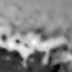

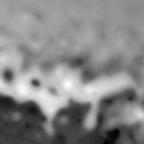

In [9]:
for batch in ssh_train.take(1):
    for i in range(1):
        display(array_to_img(batch[0][i]))
        display(array_to_img(batch[1][i]))

### SRCNN + SubPixel

In [10]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "./tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

callbacks = [early_stopping_callback, model_checkpoint_callback]
model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.002)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    1664      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 4)     1156      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             

In [11]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn, metrics=['mse', psnr]
)


Training (to skip)

In [12]:
history = model.fit(
    ssh_train, epochs=epochs, callbacks=callbacks, validation_data=ssh_valid, verbose=1
)

model.save('tmp/model/srcnn')

Epoch 1/100
43/43 [==============================] - 14s 311ms/step - loss: 0.0213 - mse: 0.0213 - psnr: 23.4169 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_psnr: 0.0000e+00
Epoch 2/100
43/43 [==============================] - 13s 310ms/step - loss: 4.1952e-04 - mse: 4.1952e-04 - psnr: 34.1178 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_psnr: 0.0000e+00
Epoch 3/100
43/43 [==============================] - 13s 307ms/step - loss: 1.6399e-04 - mse: 1.6399e-04 - psnr: 37.9611 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_psnr: 0.0000e+00
Epoch 4/100
43/43 [==============================] - 15s 334ms/step - loss: 1.2440e-04 - mse: 1.2440e-04 - psnr: 39.2282 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_psnr: 0.0000e+00
Epoch 5/100
43/43 [==============================] - 14s 314ms/step - loss: 9.7547e-05 - mse: 9.7547e-05 - psnr: 40.3464 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_psnr: 0.0000e+00
Epoch 6/100
43/43 [==============================] - 13s 308ms/

43/43 [==============================] - 14s 323ms/step - loss: 7.7125e-05 - mse: 7.7125e-05 - psnr: 42.6054 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_psnr: 0.0000e+00
Epoch 45/100
43/43 [==============================] - 12s 287ms/step - loss: 2.1046e-05 - mse: 2.1046e-05 - psnr: 46.9279 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_psnr: 0.0000e+00
Epoch 46/100
43/43 [==============================] - 13s 307ms/step - loss: 1.7827e-05 - mse: 1.7827e-05 - psnr: 47.5435 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_psnr: 0.0000e+00
Epoch 47/100
43/43 [==============================] - 13s 308ms/step - loss: 1.7721e-05 - mse: 1.7721e-05 - psnr: 47.5774 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_psnr: 0.0000e+00
Epoch 48/100
43/43 [==============================] - 15s 357ms/step - loss: 4.8957e-05 - mse: 4.8957e-05 - psnr: 45.6014 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_psnr: 0.0000e+00
Epoch 49/100
43/43 [==============================] - 16s 368ms

2022-04-28 21:22:37.997690: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: tmp/model/srcnn/assets


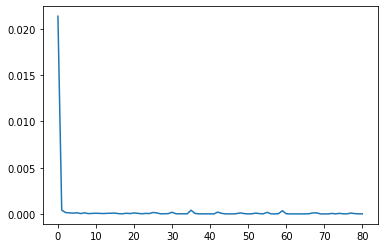

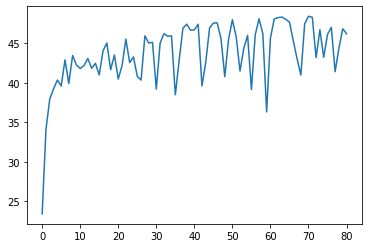

In [13]:
plt.plot(history.history['mse'])
plt.figure()
plt.plot(history.history['psnr'])

Results

In [14]:
model.load_weights(checkpoint_filepath)

In [15]:
import os
dataset = os.path.join(PATH_SAVE_SSH)
test_path = os.path.join(dataset)

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

<Figure size 432x288 with 0 Axes>

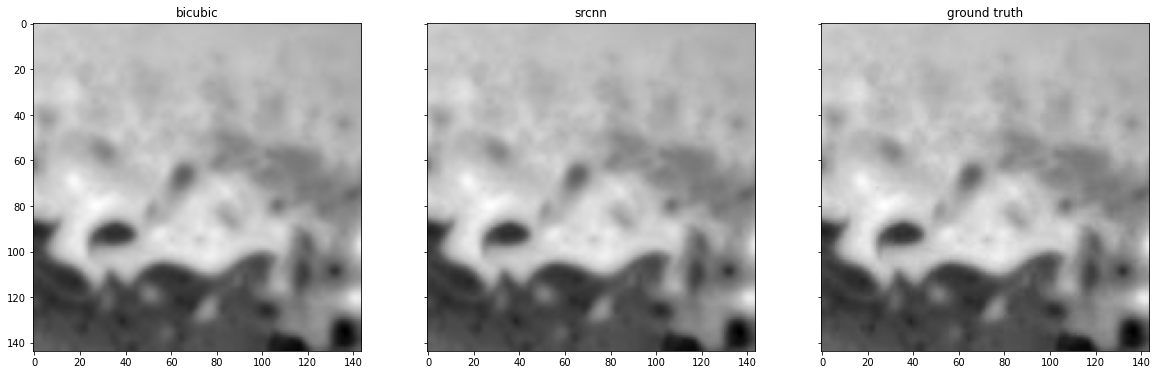

PSNR of Bicubic and Ground Truth image is 48.1378
PSNR of Prediction and Ground Truth is 47.8316


<Figure size 432x288 with 0 Axes>

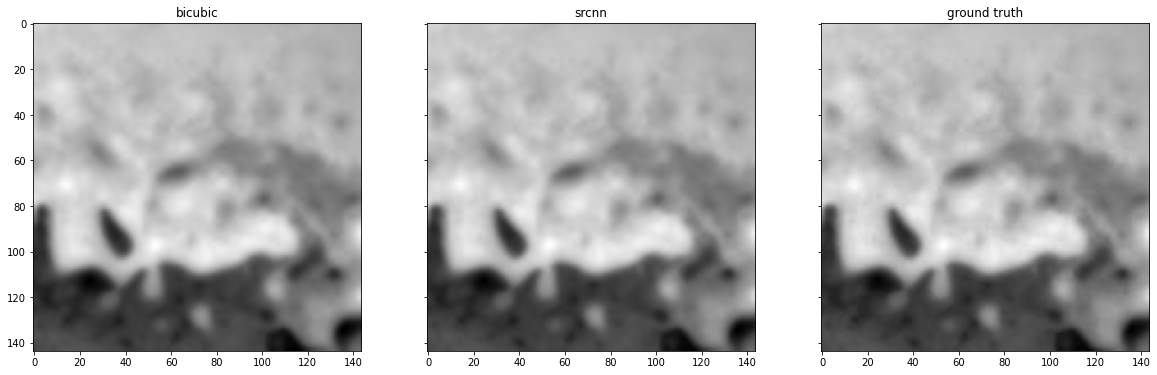

PSNR of Bicubic and Ground Truth image is 44.9399
PSNR of Prediction and Ground Truth is 46.0381


<Figure size 432x288 with 0 Axes>

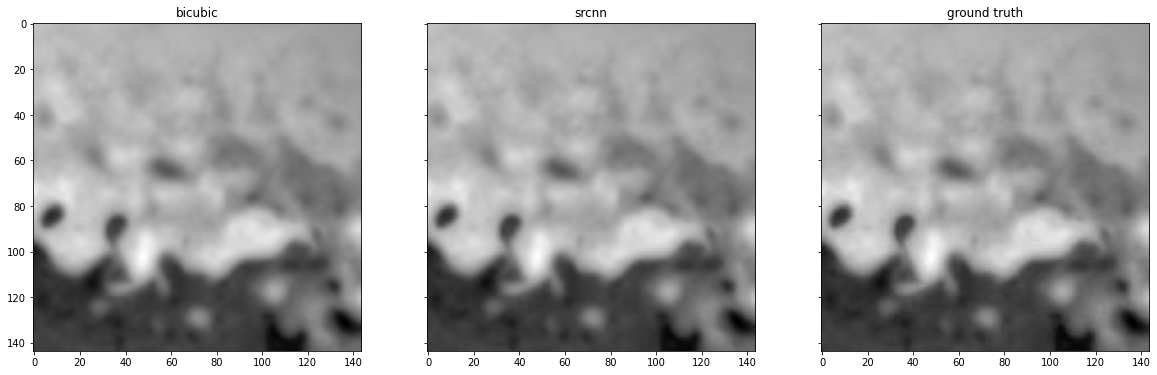

PSNR of Bicubic and Ground Truth image is 46.0333
PSNR of Prediction and Ground Truth is 46.9519


<Figure size 432x288 with 0 Axes>

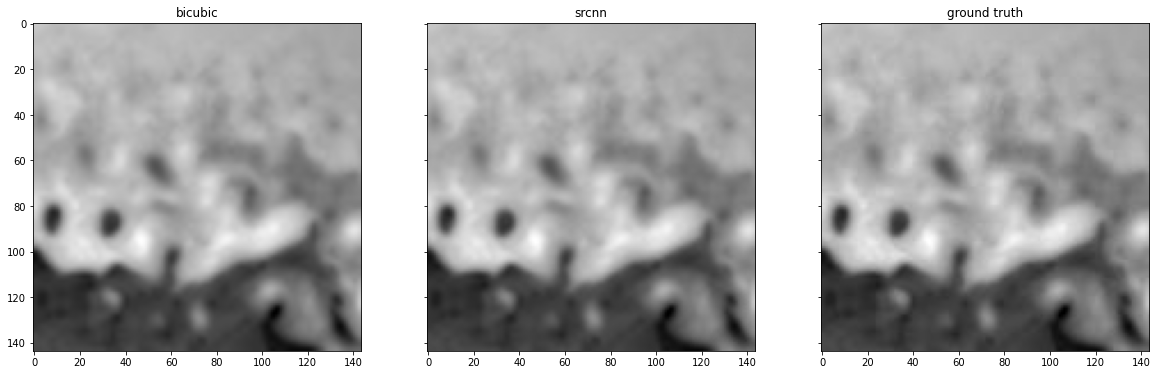

PSNR of Bicubic and Ground Truth image is 47.9168
PSNR of Prediction and Ground Truth is 47.3631


<Figure size 432x288 with 0 Axes>

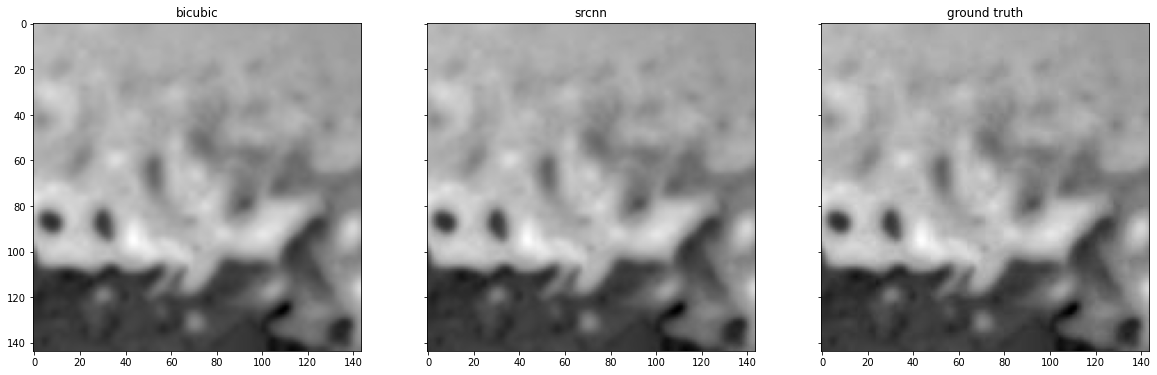

PSNR of Bicubic and Ground Truth image is 43.5408
PSNR of Prediction and Ground Truth is 47.7958


<Figure size 432x288 with 0 Axes>

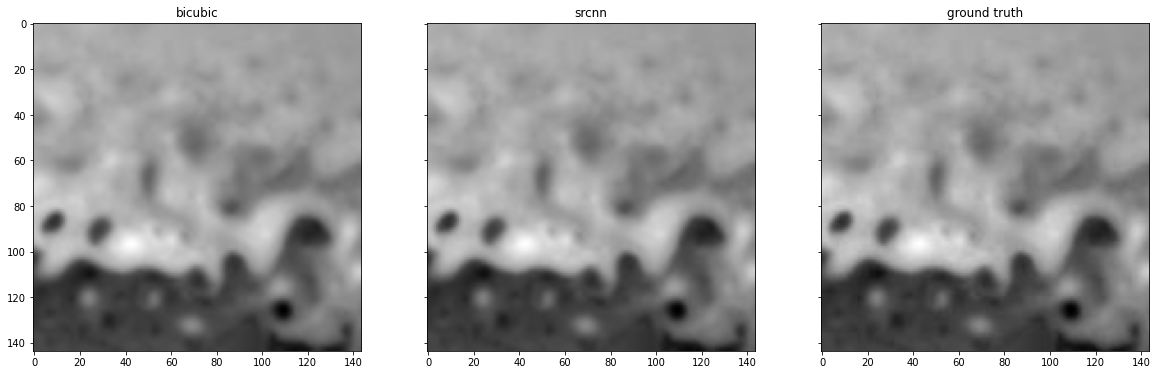

PSNR of Bicubic and Ground Truth image is 41.9601
PSNR of Prediction and Ground Truth is 48.0573


<Figure size 432x288 with 0 Axes>

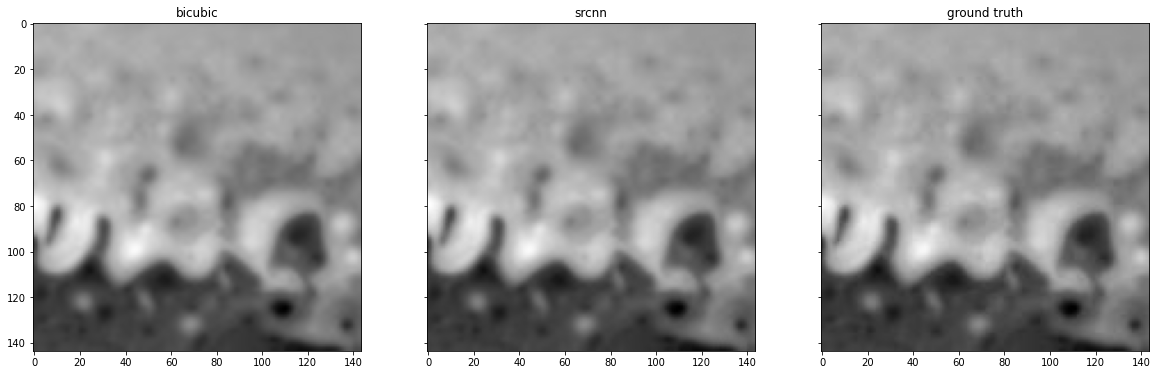

PSNR of Bicubic and Ground Truth image is 38.0871
PSNR of Prediction and Ground Truth is 43.6789


<Figure size 432x288 with 0 Axes>

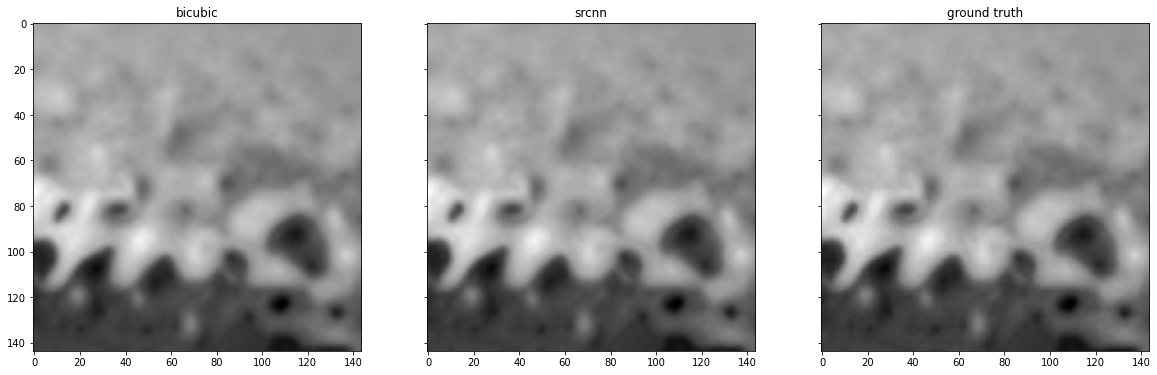

PSNR of Bicubic and Ground Truth image is 47.1284
PSNR of Prediction and Ground Truth is 47.7445


<Figure size 432x288 with 0 Axes>

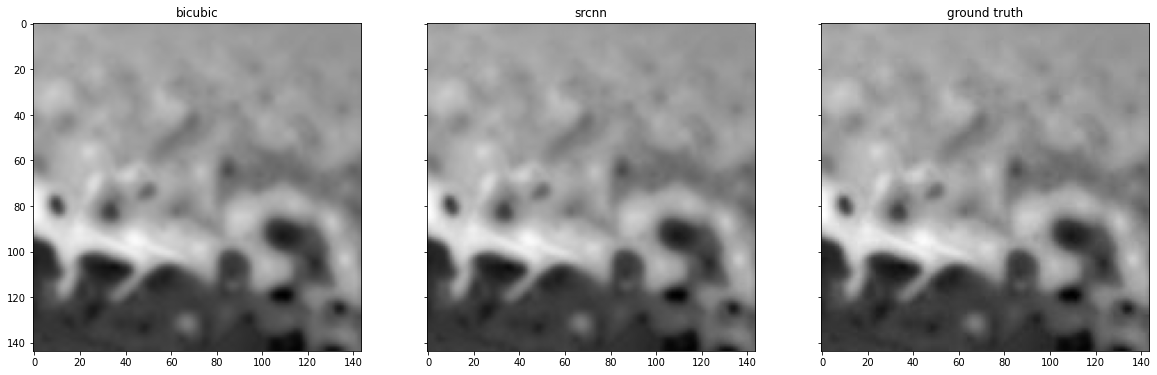

PSNR of Bicubic and Ground Truth image is 48.2732
PSNR of Prediction and Ground Truth is 46.9832


<Figure size 432x288 with 0 Axes>

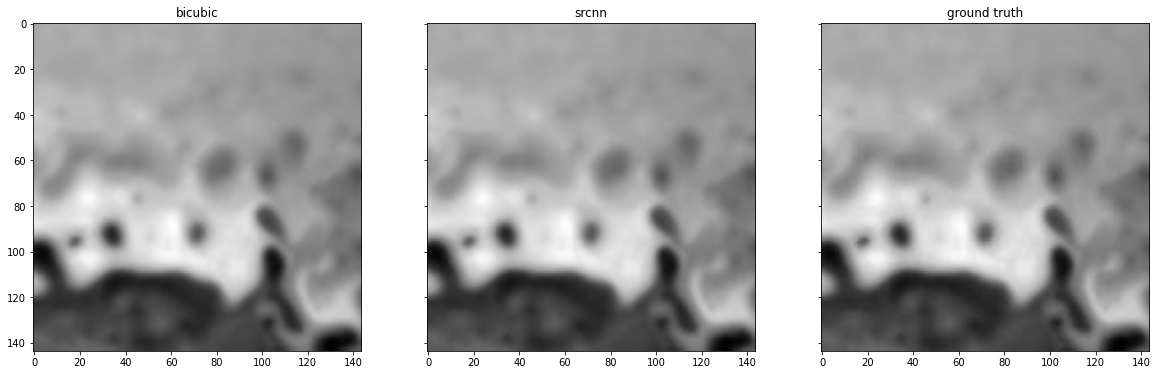

PSNR of Bicubic and Ground Truth image is 48.2794
PSNR of Prediction and Ground Truth is 48.2656
Avg. PSNR for BICUBIC is 46.2957
Avg. PSNR for PREDICTION is 46.9061


In [16]:
#model = keras.models.load_model('tmp/model/srcnn')
test_srcnn(model, test_img_paths)

On fait un peu mieux que l'interpolation bicubique en moyenne avec un SRCNN.

### Model

In [24]:
filters = 64
upscale_factor = 2

In [25]:
def simple_conv_model( shape=1, filters=filters ):
    ''' extracts SST features '''
    input_img = Input(shape=(None, None, shape))
    x = Conv2D(filters, (3,3), padding='same')(input_img)
    x = LeakyReLU(alpha=0.2)(x)        
    x = Conv2D(filters, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    return Model(inputs=input_img, outputs=x)

In [26]:
def shuffle_model( filters=filters ):
    ''' upsamples in feature branch '''
    input_img = Input(shape=(None, None, filters))
    x = Conv2D(filters, (3,3), padding='same')(input_img)
    x = depth_to_space(x, upscale_factor)        
    x = Conv2D(filters, (2,2), padding='same')(x)
    x = LeakyReLU()(x)
    return Model(inputs=input_img, outputs=x)

In [27]:
def upsample_model( shape=1, filters=filters ):
    ''' upsamples SSH '''
    input_img = Input(shape=(None, None, shape))
    upsample = Conv2DTranspose(filters, (4,4), strides=(2,2), padding='same')(input_img)
    return Model(inputs=input_img, outputs=upsample)

In [28]:
def net():
    simple_conv_1 = simple_conv_model(1)
    simple_conv_2 = simple_conv_model(filters)
    shuffle = shuffle_model()
    #upsample_1 = upsample_1_model()
    upsample_1 = upsample_model(1)
    upsample_2 = upsample_model(filters)
    
    input_hr = Input(shape=(None, None, 1))
    input_lr = Input(shape=(None, None, 1))
    
    # firstPass
    x = simple_conv_1(input_hr)
    y = upsample_1(input_lr)
    hr = Add()([y, x])
    # secondPass
    x = shuffle(x)
    x = simple_conv_2(x)
    y = upsample_2(hr)
    hr = Add()([y, x])
    
    return Model(inputs=[input_lr, input_hr], outputs=hr)

### Train the model

In [29]:
loss = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [30]:
model = net()
model.compile(optimizer=optimizer, loss=loss)